<a href="https://colab.research.google.com/github/amitaipat-create/Session2/blob/main/Copy_of_Embeddings_and_Vector_DB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

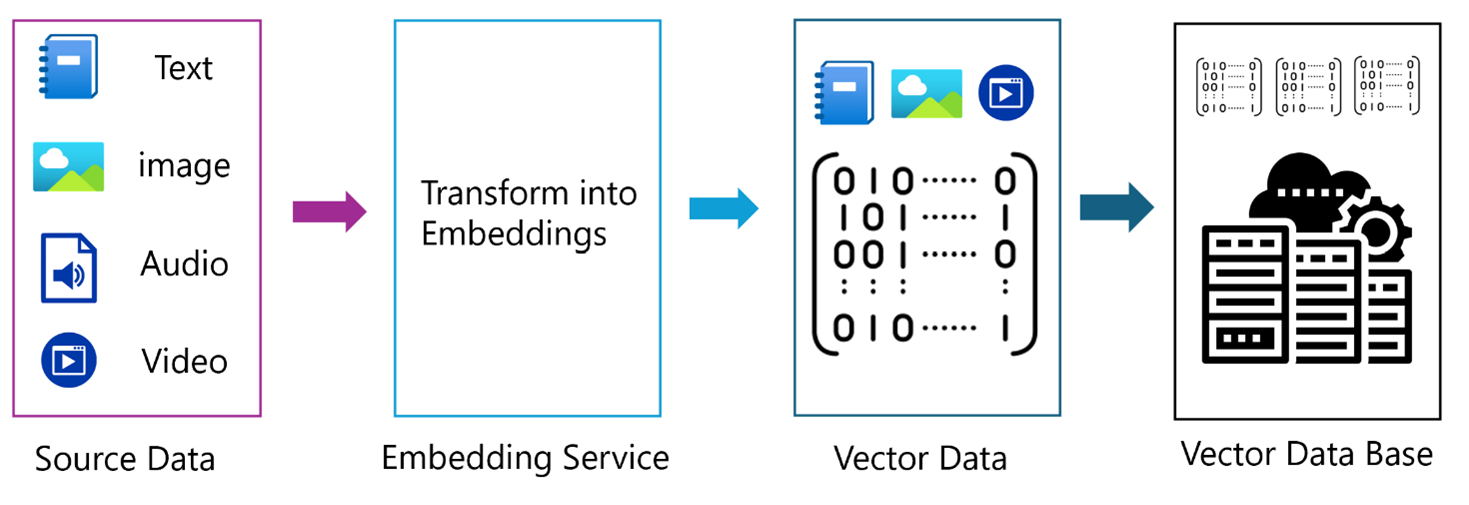


# Embeddings, Vector Databases

Welcome to this hands-on notebook! 🚀  
In this session, we’ll cover step by step:

1. **Embeddings** → turning text into vectors  
2. **Vector Databases** → storing & searching vectors  
3. **Similarity Search** → semantic retrieval  

By the end, you’ll have a complete workflow of how modern AI apps like **Chat with your PDF** work.



## ⚙️ Setup

We’ll install required libraries and set up the OpenAI API key.


In [1]:
!pip install openai faiss-cpu --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.5 MB/s eta 0:00:00


In [2]:
import os
from getpass import getpass
import numpy as np
import faiss
from openai import OpenAI

# 🔑 Enter your OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")
client = OpenAI()

Enter your OpenAI API key: ··········



# 1️⃣ Embeddings

### 🔹 What are embeddings?
- Embeddings are **vectors (lists of numbers)** that represent the meaning of text.  
- Similar meanings → vectors are closer in space.  
- We can compare vectors using **cosine similarity**.

👉 Let’s start with a simple example: convert text → vector.


# Create your first embedding

#### Step 1: Choose a piece of text.
This is the sentence we want the AI to understand in "number form."

In [3]:
text = "I love playing football"

#### Step 2: Send the text to OpenAI's embedding model.
The model converts the sentence into a long list of numbers (a vector)
You can either use text-embedding-3-small or text-embedding-3-large model

In [4]:
response = client.embeddings.create(
    input=text,
    model="text-embedding-3-small"   # smaller, faster, cheaper
)

#### Step 3: Extract the embedding vector from the response

In [5]:
embedding = response.data[0].embedding

#### Step 4: See what we got!

In [6]:
print("Original text:", text)
print("Number of values in this vector:", len(embedding))
print("First 10 numbers (out of thousands):")
print(embedding[:10])

Original text: I love playing football
Number of values in this vector: 1536
First 10 numbers (out of thousands):
[-0.004255448468029499, -0.0015121187316253781, -0.03146163374185562, -0.0031736562959849834, 0.009198224171996117, -0.03330247104167938, 0.041574299335479736, 0.01718914322555065, -0.040546298027038574, 0.01910170540213585]



### Comparing multiple sentences

#### Step 1: Let's start with a few short sentences.


In [7]:
sentences = [
    "I love playing football",
    "Soccer is my favorite sport",
    "I enjoy cooking pasta",
    "Virat Kohli is an Indian cricketer"
]

#### Step 2: Create embeddings for each sentence.
Each embedding is a list of numbers that captures the sentence's meaning.

In [8]:
embeddings = []
for sentence in sentences:
    response = client.embeddings.create(
        input=sentence,
        model="text-embedding-3-small"
    )
    embeddings.append(response.data[0].embedding)

print("✅ Created embeddings for", len(sentences), "sentences.")

✅ Created embeddings for 4 sentences.


In [9]:
for embedding in embeddings:
  print(embedding[:10])

[-0.004297963809221983, -0.0015108628431335092, -0.03146659582853317, -0.003189101116731763, 0.00917576439678669, -0.03330772742629051, 0.041604768484830856, 0.01715599000453949, -0.04055269435048103, 0.019104719161987305]
[0.015918424353003502, -0.035234544426202774, -0.016933321952819824, 0.008295672945678234, 0.009906268678605556, -0.0014285766519606113, 0.011649242602288723, 0.06310006231069565, -0.036492135375738144, -0.02715950272977352]
[-0.02917190082371235, -0.06984614580869675, -0.014145434834063053, -0.0527149960398674, 0.03546148166060448, -0.054428111761808395, -0.008632875978946686, 0.012279363349080086, -0.00914681050926447, -0.025060424581170082]
[-0.014433582313358784, 0.05061500519514084, -0.008941532112658024, 0.02088335156440735, -0.014594614505767822, -0.005797164048999548, 0.05515781044960022, 0.008060092106461525, 0.012475768104195595, 0.0003318643430247903]


#### Step 3: Define a simple cosine similarity function.
This measures how close two vectors are in meaning.
- If the value is close to 1, two vectors are similar.
- If the value is close to 0, two vectors are dissimilar.
- If the value is close to -1, two vectors are opposite.

In [10]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

#### Step 4: Compare the first sentence with all the others.

In [11]:
base_sentence = sentences[0]
print("\nComparing all sentences with:", base_sentence)
print("-" * 60)

for i in range(1, len(sentences)):
    similarity = cosine_similarity(embeddings[0], embeddings[i])
    print(f"'{base_sentence}'  ↔  '{sentences[i]}'  →  Similarity: {similarity:.3f}")


Comparing all sentences with: I love playing football
------------------------------------------------------------
'I love playing football'  ↔  'Soccer is my favorite sport'  →  Similarity: 0.581
'I love playing football'  ↔  'I enjoy cooking pasta'  →  Similarity: 0.336
'I love playing football'  ↔  'Virat Kohli is an Indian cricketer'  →  Similarity: 0.164



💡 **Try it yourself**: Replace the sentences with your own examples and rerun!



# 2️⃣ Vector Database

### 🔹 Why do we need it?
- With 5 texts, brute force comparison is easy.  
- With 5 million, we need efficient storage + fast search.  
- That’s where **Vector Databases (like FAISS)** come in.

👉 Let’s store our embeddings in FAISS and run similarity search.


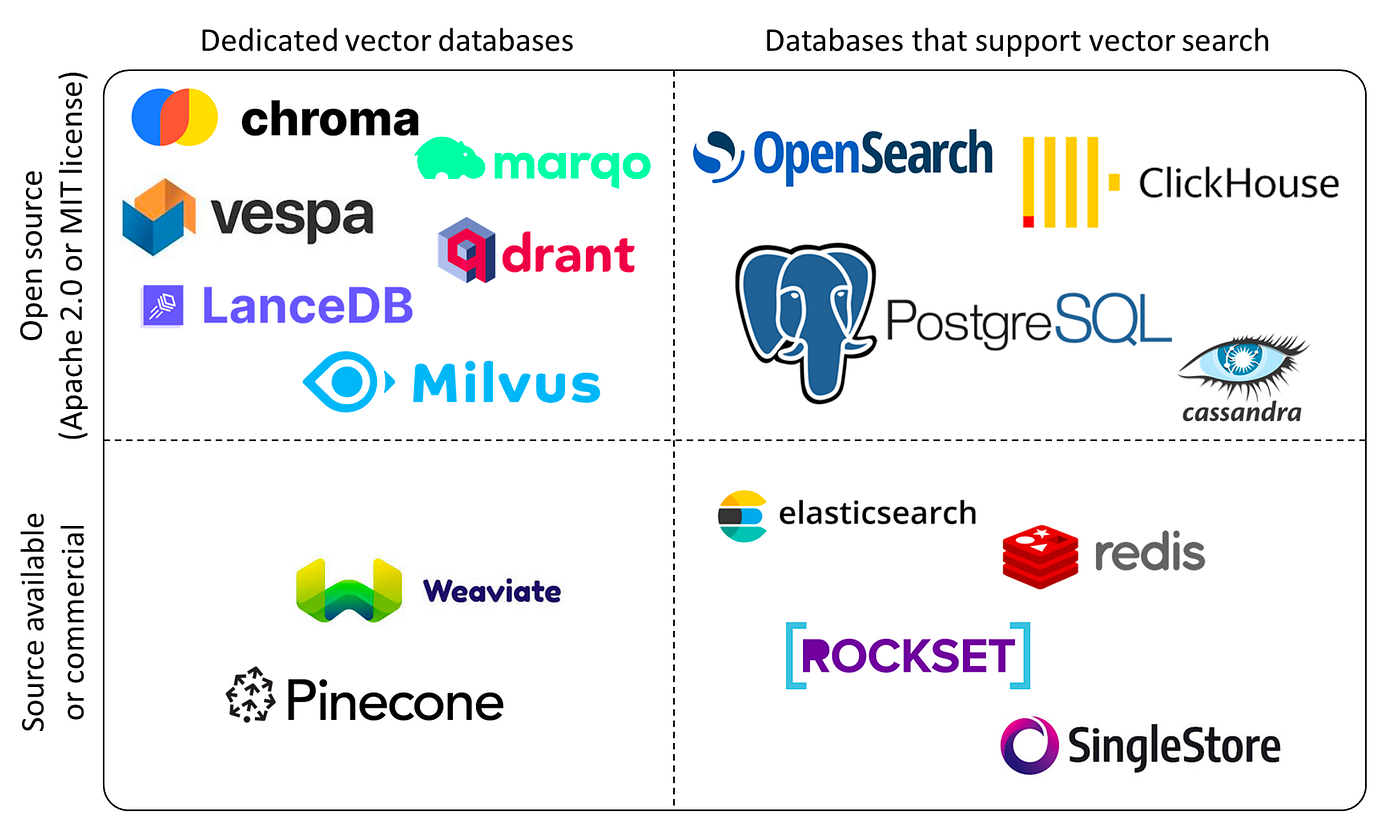

#### Store all our embeddings in a Vector Database (FAISS)

##### Step 1: Convert our list of embeddings into a NumPy array.
FAISS works best with arrays of type float32 (not plain Python lists).

In [12]:
embedding_matrix = np.array(embeddings).astype("float32")

print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (4, 1536)


#### Step 2: Create an empty FAISS index.
An "index" is like a shelf where all embeddings will be stored.
We'll use L2 (Euclidean) distance to measure similarity.

In [13]:
index = faiss.IndexFlatL2(embedding_matrix.shape[1])

#### Step 3: Add all embeddings to the index (our mini vector database!)

In [14]:
index.add(embedding_matrix)

print(f"✅ Added {index.ntotal} embeddings to the vector database.")

✅ Added 4 embeddings to the vector database.


# Search by meaning

##### Step 1: Let's ask the database a question in plain English.

In [15]:
query = "I like football"

#### Step 2: Convert this query into an embedding (same model as before)
Remember: both our data AND our query must live in the same "meaning space".

In [16]:
response = client.embeddings.create(
    input=query,
    model="text-embedding-3-small"
)
print(response.data[0].embedding)

[-0.006978098303079605, -0.006735760252922773, -0.046926625072956085, 0.010600744746625423, 0.013657934963703156, -0.007674043998122215, 0.03407648578286171, 0.01134640071541071, -0.029801389202475548, 0.009786736220121384, -0.02642108127474785, -0.0075186993926763535, -0.039494920521974564, 0.050630051642656326, 0.018579265102744102, 0.00607709726318717, -0.06874949485063553, -0.009065935388207436, 0.03556779772043228, -0.012924705632030964, 0.027862682938575745, 0.021773159503936768, 0.04369544982910156, -0.030845308676362038, -0.00289407791569829, 0.03223719820380211, 0.028931457549333572, 0.03594062477350235, -0.04337232932448387, 0.02793724834918976, 0.055079132318496704, -0.026595067232847214, -0.02092808112502098, -0.032958000898361206, 0.0325603187084198, -0.020555254071950912, 0.03653714805841446, 0.012763147242367268, 0.03034820407629013, 0.01813187077641487, 0.05975190922617912, 0.03730766102671623, 0.020406123250722885, -0.05072947219014168, -0.0045018987730145454, 0.004042

In [17]:
query_vector = np.array([response.data[0].embedding]).astype("float32")
print(query_vector)

[[-0.0069781  -0.00673576 -0.04692663 ...  0.01614345  0.01349638
   0.05473116]]


#### Step 3: Ask FAISS to find the most similar vectors (nearest neighbors)
'k=2' means: return the top 2 most similar results

In [18]:
distances, indices = index.search(query_vector, k=2)

#### Step 4: Show what the database found

In [19]:
print("🔍 Query:", query)
print("\nTop Matches (by meaning):\n")

for rank, idx in enumerate(indices[0], start=1):
    print(f"{rank}. {sentences[idx]}  (distance: {distances[0][rank-1]:.4f})")

🔍 Query: I like football

Top Matches (by meaning):

1. I love playing football  (distance: 0.3415)
2. Soccer is my favorite sport  (distance: 0.8004)


[Click Here For Additional Exercise For Practice](https://docs.google.com/document/d/1o_oGUIxfbedcO5aeYfwtTsPCE3oSUuHPvstTxrcbRrY/edit?tab=t.0)